# Notebook 1: Simulation of a Homogeneous Cell Population

### Objective
This notebook simulates a realistic dataset representing a single, homogeneous population of cells. The goal is to create a ground truth dataset to validate a deconvolution model. The simulation generates known mitochondrial cluster signatures and a population of cells whose mitochondrial compositions are all slight variations of a single, central "true" set of proportions. It includes several configurable parameters to control the characteristics of the data, such as the number of mutations per cluster and the distribution of cluster sizes.

The final output is a single compressed file, `simulated_data_regression.npz`, containing all the necessary data for the modeling step.

In [85]:
### Cell 1: Imports and Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Simulation Configuration ---
N_CLUSTERS = 30
N_LOCATIONS = 16500
N_CELLS = 1000
MIN_VARIANTS_PER_CLUSTER = 5
MAX_VARIANTS_PER_CLUSTER = 50

# --- New Configurable Parameters ---
# Controls variation between cells. Higher value = more homogeneous.
HOMOGENEITY_ALPHA = 100.0 
# Controls the amount of simulated sequencing noise.
NOISE_LEVEL = 0.01

# Controls the skew towards less-mutated clusters. Higher value = stronger skew.
SKEW_FACTOR = 2.0
# Controls the distribution of the number of mutations per cluster.
# shape = 0 -> uniform distribution. shape > 1 -> strong skew to low mutation counts.
MUTATION_DENSITY_SHAPE = 1.5

# Controls the skew of proportion sizes. Higher value = more dominant clusters.
PROPORTION_SKEW = 5.0

In [86]:
### Cell 2: Data Generation Function

def generate_homogeneous_data(n_clusters, n_locations, n_cells, min_variants, max_variants, 
                              homogeneity_alpha, noise_level, skew_factor, mutation_shape, proportion_skew):
    """
    Generates data for a single homogeneous population of cells, with control
    over the mean cluster sizes and the distribution of mutations per cluster.
    """
    
    # 1. Define Ground Truth Cluster Signatures (K_true)
    print("1. Generating known mitochondrial cluster signatures (K_true)...")
    
    # --- Create a controllable distribution for the number of variants ---
    possible_counts = np.arange(min_variants, max_variants + 1)
    probabilities = 1 / (possible_counts**mutation_shape + 1e-9)
    probabilities /= probabilities.sum() 
    
    K_true = np.zeros((n_locations, n_clusters))
    for i in range(n_clusters):
        num_variants = np.random.choice(possible_counts, p=probabilities)
        mut_sites = np.random.choice(n_locations, num_variants, replace=False)
        K_true[mut_sites, i] = 1.0

    # 2. Define "True" Mean Proportions, biased by mutation count and proportion skew
    print("2. Simulating proportions, with skew for dominant clusters...")
    
    num_variants_per_cluster = np.sum(K_true, axis=0)
    
    # Create a base for proportions, inversely related to the number of variants
    base_proportions = 1 / ((num_variants_per_cluster + 1) ** skew_factor)
    
    # Create a skewed alpha vector for the Dirichlet distribution
    # This will generate a few large proportions and many small ones.
    dirichlet_alpha = base_proportions ** proportion_skew
    dirichlet_alpha = (dirichlet_alpha / dirichlet_alpha.sum()) * n_clusters
    
    # Draw the final proportions from this skewed Dirichlet distribution
    true_mean_proportions = np.random.dirichlet(dirichlet_alpha)
    
    # 3. For each cell, simulate a slight variation from the mean proportions
    cell_proportions_list = []
    
    true_mean_props_safe = np.where(true_mean_proportions == 0, 1e-6, true_mean_proportions)
    for _ in range(n_cells):
        cell_props = np.random.dirichlet(homogeneity_alpha * true_mean_props_safe)
        cell_proportions_list.append(cell_props)
            
    P_cells_true = np.array(cell_proportions_list)

    # 4. Generate "Observed" Data based on individual cells
    print("4. Generating 'observed' VAFs for each cell with simulated noise...")
    C_true = P_cells_true @ K_true.T 

    C_observed = C_true + np.random.normal(0, noise_level, size=C_true.shape)
    C_observed = np.clip(C_observed, 0, 1) 

    print("\n--- Data Simulation Complete ---")
    
    return {
        "K_true": K_true,
        "P_cells_true": P_cells_true,
        "C_observed": C_observed,
        "true_mean_proportions": true_mean_proportions,
        "num_variants_per_cluster": num_variants_per_cluster
    }

1. Generating known mitochondrial cluster signatures (K_true)...
2. Simulating proportions, with skew for dominant clusters...
4. Generating 'observed' VAFs for each cell with simulated noise...

--- Data Simulation Complete ---


/tmp/ipykernel_285337/1098793144.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(N_CLUSTERS), y=mean_props, ax=axes[1], palette="viridis")


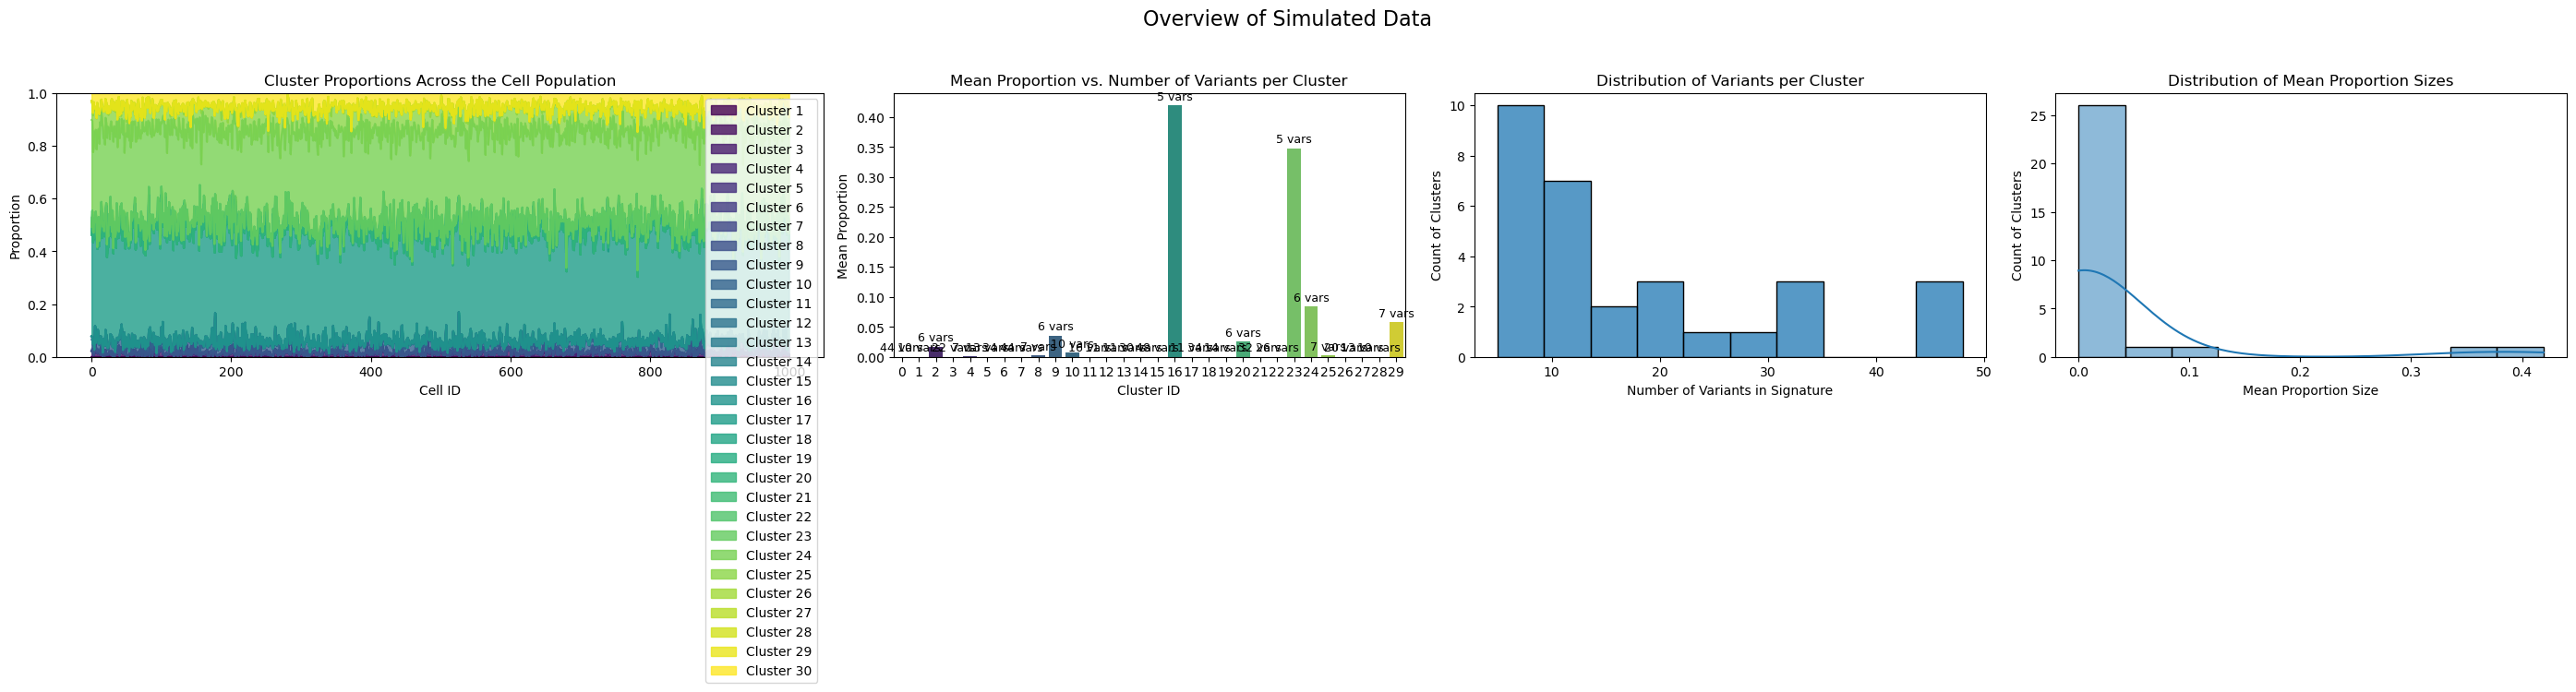

In [87]:
### Cell 3: Execute Simulation and Visualize

simulated_data = generate_homogeneous_data(
    N_CLUSTERS, 
    N_LOCATIONS, 
    N_CELLS, 
    MIN_VARIANTS_PER_CLUSTER, 
    MAX_VARIANTS_PER_CLUSTER,
    HOMOGENEITY_ALPHA,
    NOISE_LEVEL,
    SKEW_FACTOR,
    MUTATION_DENSITY_SHAPE,
    PROPORTION_SKEW
)

# --- Visualization ---
fig, axes = plt.subplots(1, 4, figsize=(28, 6), gridspec_kw={'width_ratios': [3, 2, 2, 2]})
fig.suptitle('Overview of Simulated Data', fontsize=16)


# Plot 1: The distribution of proportions across all cells
p_df = pd.DataFrame(simulated_data['P_cells_true'], columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
p_df.plot(kind='area', stacked=True, ax=axes[0], colormap='viridis', alpha=0.8)
axes[0].set_title('Cluster Proportions Across the Cell Population')
axes[0].set_xlabel('Cell ID')
axes[0].set_ylabel('Proportion')
axes[0].legend(loc='upper right')
axes[0].set_ylim(0, 1)

# Plot 2: The relationship between variant count and mean proportion size
variant_counts = simulated_data['num_variants_per_cluster']
mean_props = simulated_data['true_mean_proportions']
sns.barplot(x=np.arange(N_CLUSTERS), y=mean_props, ax=axes[1], palette="viridis")
axes[1].set_title('Mean Proportion vs. Number of Variants per Cluster')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Mean Proportion')
# Add text labels for variant counts
for i, count in enumerate(variant_counts):
    axes[1].text(i, mean_props[i] + 0.005, f'{int(count)} vars', ha='center', va='bottom', fontsize=9)

# Plot 3: Histogram of the number of variants per cluster
sns.histplot(data=variant_counts, ax=axes[2], bins=10, kde=False)
axes[2].set_title('Distribution of Variants per Cluster')
axes[2].set_xlabel('Number of Variants in Signature')
axes[2].set_ylabel('Count of Clusters')

# Plot 4: Histogram of the mean proportion sizes
sns.histplot(data=mean_props, ax=axes[3], bins=10, kde=True)
axes[3].set_title('Distribution of Mean Proportion Sizes')
axes[3].set_xlabel('Mean Proportion Size')
axes[3].set_ylabel('Count of Clusters')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [88]:
### Cell 4: Save Simulated Data to File

output_filename = '../sim_data/simulated_data_regression_02.npz'
np.savez_compressed(output_filename, **simulated_data)
print(f"\nSimulated data successfully saved to '{output_filename}'")


Simulated data successfully saved to '../sim_data/simulated_data_regression_02.npz'
